### Add libraries

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import pickle
import numpy as np


### Calgary road graph data load

In [5]:
calgary_graph = ox.io.load_graphml('./mapGraphs/calgary_drive_network_updated.graphml')

In [3]:
# Convert edge data to a pandas dataframe
edge_data = ox.graph_to_gdfs(calgary_graph, nodes=False, edges=True)

edge_data = edge_data.reset_index()
for i in range(len(edge_data)):
    u = edge_data.iloc[i]['u']
    v = edge_data.iloc[i]['v']
    key = edge_data.iloc[i]['key']
    sl_l = float(edge_data.iloc[i]['slopized_length']) if float(edge_data.iloc[i]['slopized_length']) > 0.0 else 0.005
    sl_l2 = float(edge_data.iloc[i]['grade_abs']) if float(edge_data.iloc[i]['grade_abs']) > 0.0 else 0.005
    ed_tr = int(edge_data.iloc[i]['edge_tree_count']) if int(edge_data.iloc[i]['edge_tree_count']) > 0 else 1
    calgary_graph[u][v][key]['slopized_length'] = sl_l
    calgary_graph[u][v][key]['grade_abs'] = sl_l2
    calgary_graph[u][v][key]['edge_tree_count'] = 1000 - ed_tr

KeyboardInterrupt: 

In [4]:
# Update the edge data in the graph
ox.io.save_graphml(calgary_graph, './mapGraphs/calgary_drive_network_updated2.graphml')

In [37]:
calgary_graph = ox.io.load_graphml('./mapGraphs/calgary_drive_network_updated.graphml')
nodes_gdf, edges_gdf = ox.graph_to_gdfs(calgary_graph)
edges_gdf['edge_tree_count'] = edges_gdf['edge_tree_count'].astype(int)
edges_gdf['slopized_length'] = edges_gdf['slopized_length'].astype(float)
# convert the pair of GeoDataFrames to a networkx graph object
calgary_graph = ox.graph_from_gdfs(nodes_gdf, edges_gdf)


### Main Function

In [38]:
# set default weights for the criteria
distance_weight = 0.5
weather_weight = 0.3
emission_weight = 0.2

# get user input for the weights
dist_weight = float(input("Enter weight for distance (default 0.5): ") or distance_weight)
weather_weight = float(input("Enter weight for extreme weather (default 0.3): ") or weather_weight)
emission_weight = float(input("Enter weight for gas emission (default 0.2): ") or emission_weight)

# Define the start and end points
start_point = (51.090632, -114.153066)
end_point = (51.144618, -114.104486)
# find the shortest path using Dijkstra's algorithm
start = input("Select the starting point: ") or start_point
end = input("Select the ending point: ") or end_point


# Find the nearest node in the graph to the start and end points
start_node = ox.distance.nearest_nodes(calgary_graph, start_point[1], start_point[0])
end_node = ox.distance.nearest_nodes(calgary_graph, end_point[1], end_point[0])

# Find the shortest path between the start and end nodes
shortest_path_lenght = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='length')
shortest_path_road_slope = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='slopized_length')
shortest_path_tree_count = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='edge_tree_count')

# Print the edges in the shortest path
print(shortest_path_tree_count)




[5192190535, 672991372, 251503494, 28912478, 251504458, 251504517, 122962001, 2786961189, 122961916, 31363131, 29174983, 109682018, 513891635, 513892197, 170034147, 170034211, 623807994, 254039118, 83742210, 4600168001, 83742209, 856157271, 856157328, 2194922269, 1452767313, 4462008319, 4426108290, 2194922273, 302749007, 1452767392, 480021472, 617502334, 480021528, 617501795, 617501796, 168337173]


In [14]:
# set default weights for the criteria
distance_weight = 0.5
weather_weight = 0.3
emission_weight = 0.2

# get user input for the weights
dist_weight = float(input("Enter weight for distance (default 0.5): ") or distance_weight)
weather_weight = float(input("Enter weight for extreme weather (default 0.3): ") or weather_weight)
emission_weight = float(input("Enter weight for gas emission (default 0.2): ") or emission_weight)

# Define the start and end points
start_point = (51.090632, -114.153066)
end_point = (51.144618, -114.104486)
# find the shortest path using Dijkstra's algorithm
start = input("Select the starting point: ") or start_point
end = input("Select the ending point: ") or end_point


# Find the nearest node in the graph to the start and end points
start_node = ox.distance.nearest_nodes(calgary_graph, start_point[1], start_point[0])
end_node = ox.distance.nearest_nodes(calgary_graph, end_point[1], end_point[0])

# Find the shortest path between the start and end nodes
shortest_path_lenght = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='length')
shortest_path_road_slope = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='slopized_length')
shortest_path_tree_count = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='edge_tree_count')



# Choose the path with the highest weighted score as the best path
best_path = min([shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count], key=lambda path: distance_weight * ox.distance.great_circle_vec(calgary_graph.nodes[path[0]]['y'], calgary_graph.nodes[path[0]]['x'], calgary_graph.nodes[path[-1]]['y'], calgary_graph.nodes[path[-1]]['x']) + weather_weight * sum([calgary_graph.edges[u, v, 0]['slopized_length'] for u, v in zip(path[:-1], path[1:])]) + emission_weight * sum([calgary_graph.edges[u, v, 0].get('edge_tree_count', 0) for u, v in zip(path[:-1], path[1:])]))
print(f'Best Path: {best_path}')


Best Path: [5192190535, 672991372, 251503494, 28912478, 251504458, 29024622, 29024614, 29024624, 577474879, 170034141, 30996312, 4544977765, 577474912, 109682018, 513891635, 513892197, 170034147, 170034211, 623807994, 254039118, 83742210, 4600168001, 83742209, 856157271, 856157328, 2194922269, 1452767313, 4462008319, 4426108290, 2194922273, 302749007, 1452767392, 480021472, 617502334, 480021528, 617501795, 617501796, 168337173]


In [17]:
# set default weights for the criteria
distance_weight = 0.5
weather_weight = 0.3
emission_weight = 0.2

# get user input for the weights
dist_weight = float(input("Enter weight for distance (default 0.5): ") or distance_weight)
weather_weight = float(input("Enter weight for extreme weather (default 0.3): ") or weather_weight)
emission_weight = float(input("Enter weight for gas emission (default 0.2): ") or emission_weight)

# Define the start and end points
start_point = (51.090632, -114.153066)
end_point = (51.144618, -114.104486)
# find the shortest path using Dijkstra's algorithm
start = input("Select the starting point: ") or start_point
end = input("Select the ending point: ") or end_point


# Find the nearest node in the graph to the start and end points
start_node = ox.distance.nearest_nodes(calgary_graph, start_point[1], start_point[0])
end_node = ox.distance.nearest_nodes(calgary_graph, end_point[1], end_point[0])

# Find the shortest path between the start and end nodes
shortest_path_lenght = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='length')
shortest_path_road_slope = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='slopized_length')
shortest_path_tree_count = ox.distance.shortest_path(calgary_graph, start_node, end_node, weight='edge_tree_count')

# Calculate the normalized values for each criterion
max_distance = max([ox.distance.great_circle_vec(calgary_graph.nodes[path[0]]['y'], calgary_graph.nodes[path[0]]['x'], calgary_graph.nodes[path[-1]]['y'], calgary_graph.nodes[path[-1]]['x']) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]])
max_slope = max([max([calgary_graph.edges[u, v, 0]['slopized_length'] for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]])
max_tree_count = max([sum([calgary_graph.edges[u, v, 0].get('edge_tree_count', 0) for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]])
normalized_distance = [(ox.distance.great_circle_vec(calgary_graph.nodes[path[0]]['y'], calgary_graph.nodes[path[0]]['x'], calgary_graph.nodes[path[-1]]['y'], calgary_graph.nodes[path[-1]]['x']) / max_distance) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]]
normalized_slope = [([calgary_graph.edges[u, v, 0]['slopized_length'] / max_slope for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]]
normalized_tree_count = [sum([calgary_graph.edges[u, v, 0].get('edge_tree_count', 0) / max_tree_count for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]]

# Calculate the weighted score for each path
for i, path in enumerate([shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count]):
    weighted_score = (normalized_distance[i] * distance_weight) + (np.sum(normalized_slope[i]) * weather_weight) + (normalized_tree_count[i] * emission_weight)
    print(f'Path: {i}, Weighted Score: {weighted_score}')

# Choose the path with the highest weighted score as the best path
best_path = min([shortest_path_lenght, shortest_path_road_slope, shortest_path_tree_count], key=lambda path, i=i: (normalized_distance[i] * distance_weight) + (np.sum(normalized_slope[i]) * weather_weight) + (normalized_tree_count[i] * emission_weight))
print(f'Best Path: {best_path}')

Path: 0, Weighted Score: 1.4991847454745697
Path: 1, Weighted Score: 1.439692403479827
Path: 2, Weighted Score: 1.4990785799647337
Best Path: [5192190535, 672991372, 251503494, 28912478, 251504458, 29024622, 29024614, 29024624, 577474879, 170034141, 254039151, 513889079, 513880653, 29174994, 513892197, 170034147, 170034211, 623807994, 254039118, 83742210, 4600168001, 83742209, 856157271, 856157328, 2194922269, 1452767313, 4462008319, 4426108290, 2194922273, 302749007, 1452767392, 480021472, 617502334, 480021528, 617501795, 617501796, 168337173]


In [18]:

# create an empty list to store the edges
edges = []

# iterate over pairs of nodes and find the edges between them
for i in range(len(best_path)-1):
    start_node = best_path[i]
    end_node = best_path[i+1]
    out_edges = list(calgary_graph.out_edges(start_node, data=True))
    edge = None
    for u, v, d in out_edges:
        if v == end_node:
            edge = (u, v, d)
            break
    edges.append(edge)

# print the list of edges
print(edges)

[(5192190535, 672991372, {'osmid': 4684553, 'oneway': False, 'name': 'Valiant Drive NW', 'highway': 'residential', 'length': 102.85, 'grade': -0.049, 'grade_abs': 0.049, 'speed_kph': 42.2, 'travel_time': 8.8, 'bearing': 270.3, 'slopized_length': 5.03965, 'edge_tree_count': 10, 'geometry': <LINESTRING (-114.153 51.091, -114.154 51.091, -114.154 51.091)>}), (672991372, 251503494, {'osmid': 4684553, 'oneway': False, 'name': 'Valiant Drive NW', 'highway': 'residential', 'length': 21.314, 'grade': 0.0, 'grade_abs': 0.0, 'speed_kph': 42.2, 'travel_time': 1.8, 'bearing': 264.0, 'slopized_length': 0.0021314000000000003, 'edge_tree_count': 7, 'geometry': <LINESTRING (-114.154 51.091, -114.154 51.091, -114.154 51.091)>}), (251503494, 28912478, {'osmid': 196555618, 'oneway': True, 'name': 'Shaganappi Trail NW', 'highway': 'primary', 'maxspeed': '70', 'length': 300.145, 'grade': 0.003, 'grade_abs': 0.003, 'speed_kph': 70.0, 'travel_time': 15.4, 'bearing': 354.9, 'slopized_length': 0.900435, 'edge_

In [ ]:
# find the edge between the two nodes
start_node = 5192190535
end_node = 672991372
out_edges = list(calgary_graph.out_edges(start_node, data=True))
edge = None
for u, v, d in out_edges:
    if v == end_node:
        edge = (u, v, d)
        break

print(edge)

In [9]:
import networkx as nx
import osmnx as ox
import numpy as np

class PathFinder:
    
    def __init__(self, graph_file, start_point, end_point,distance_weight,weather_weight,emission_weight):
        self.graph_file = graph_file
        self.start_point = start_point
        self.end_point = end_point
        
        # set default weights for the criteria
        self.distance_weight = distance_weight
        self.weather_weight = weather_weight
        self.emission_weight = emission_weight
    
    def graph_loader(self):
        # load the graph
        self.graph = ox.load_graphml(self.graph_file)
        nodes_gdf, edges_gdf = ox.graph_to_gdfs(self.graph)
        edges_gdf['edge_tree_count'] = edges_gdf['edge_tree_count'].astype(int)
        edges_gdf['slopized_length'] = edges_gdf['slopized_length'].astype(float)
        # convert the pair of GeoDataFrames to a networkx graph object
        self.graph = ox.graph_from_gdfs(nodes_gdf, edges_gdf)


    def find_best_path(self):
        self.graph_loader()
        # Find the nearest node in the graph to the start and end points
        self.start_node = ox.distance.nearest_nodes(self.graph, self.start_point[1], self.start_point[0])
        self.end_node = ox.distance.nearest_nodes(self.graph, self.end_point[1], self.end_point[0])

        # Find the shortest path between the start and end nodes
        #shortest_path_lenght = nx.shortest_path(self.graph, self.start_node, self.end_node, weight='length')
        #shortest_path_slope = nx.shortest_path(self.graph, self.start_node, self.end_node, weight='slopized_length')
        #shortest_path_tree_count = nx.shortest_path(self.graph, self.start_node, self.end_node, weight='edge_tree_count')

        shortest_path_lenght = ox.distance.shortest_path(self.graph, self.start_node, self.end_node, weight='length')
        shortest_path_slope = ox.distance.shortest_path(self.graph, self.start_node, self.end_node, weight='slopized_length')
        shortest_path_tree_count = ox.distance.shortest_path(self.graph, self.start_node, self.end_node, weight='edge_tree_count')

        # Calculate the normalized values for each criterion
        max_distance = max([ox.distance.great_circle_vec(self.graph.nodes[path[0]]['y'], self.graph.nodes[path[0]]['x'], self.graph.nodes[path[-1]]['y'], self.graph.nodes[path[-1]]['x']) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]])
        max_slope = max([max([self.graph.edges[u, v, 0]['slopized_length'] for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]])
        max_tree_count = max([sum([self.graph.edges[u, v, 0].get('edge_tree_count', 0) for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]])
        normalized_distance = [(ox.distance.great_circle_vec(self.graph.nodes[path[0]]['y'], self.graph.nodes[path[0]]['x'], self.graph.nodes[path[-1]]['y'], self.graph.nodes[path[-1]]['x']) / max_distance) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]]
        normalized_slope = [([self.graph.edges[u, v, 0]['slopized_length'] / max_slope for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]]
        normalized_tree_count = [sum([self.graph.edges[u, v, 0].get('edge_tree_count', 0) / max_tree_count for u, v in zip(path[:-1], path[1:])]) for path in [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]]

        # Calculate the weighted score for each path
      
        weighted_scores = []
        for i, path in enumerate([shortest_path_lenght, shortest_path_slope, shortest_path_tree_count]):
            weighted_score = (normalized_distance[i] * distance_weight) + (np.sum(normalized_slope[i]) * weather_weight) + (normalized_tree_count[i] * emission_weight)
            #print(f'Path: {i}, Weighted Score: {weighted_score}')
            weighted_scores.append(weighted_score)

        # Choose the path with the highest weighted score as the best path
        best_path_index = np.argmin(weighted_scores)
        best_path = [shortest_path_lenght, shortest_path_slope, shortest_path_tree_count][best_path_index]
        #print(f'Best Path: {best_path_index}')
        # create an empty list to store the edges
        edges = []

        # iterate over pairs of nodes and find the edges between them
        for i in range(len(best_path)-1):
            start_node = best_path[i]
            end_node = best_path[i+1]
            out_edges = list(self.graph.out_edges(start_node, data=True))
            edge = None
            for u, v, d in out_edges:
                if v == end_node:
                    edge = (u, v, d)
                    #edge = (u, v)
                    break
            edges.append(edge)
        return best_path, edges
        

In [10]:
graph_file = './mapGraphs/calgary_drive_network_updated.graphml'

# set default weights for the criteria
distance_weight = 0.1
weather_weight = 0.5
emission_weight = 0.4

# Define the start and end points
start_point = (51.090632, -114.153066)
end_point = (51.144618, -114.104486)

path_finder = PathFinder(graph_file, start_point, end_point,distance_weight,weather_weight,emission_weight)
path_finder.find_best_path()[1]

[(5192190535,
  30920053,
  {'osmid': 4684553,
   'oneway': False,
   'name': 'Valiant Drive NW',
   'highway': 'residential',
   'length': 41.866,
   'grade': -0.048,
   'grade_abs': 0.048,
   'speed_kph': 42.2,
   'travel_time': 3.6,
   'bearing': 89.2,
   'slopized_length': 2.0095680000000002,
   'edge_tree_count': 994,
   'geometry': <LINESTRING (-114.153 51.091, -114.152 51.091)>}),
 (30920053,
  30920057,
  {'osmid': 4684553,
   'oneway': False,
   'name': 'Valiant Drive NW',
   'highway': 'residential',
   'length': 52.344,
   'grade': -0.057,
   'grade_abs': 0.057,
   'speed_kph': 42.2,
   'travel_time': 4.5,
   'bearing': 89.4,
   'slopized_length': 2.9836080000000003,
   'edge_tree_count': 999,
   'geometry': <LINESTRING (-114.152 51.091, -114.151 51.091, -114.151 51.091)>}),
 (30920057,
  30920059,
  {'osmid': 4684553,
   'oneway': False,
   'name': 'Valiant Drive NW',
   'highway': 'residential',
   'length': 93.95400000000001,
   'grade': -0.011,
   'grade_abs': 0.011,
   

In [11]:
routes = path_finder.find_best_path()[1]

In [44]:
from shapely.geometry import LineString
i = 1
edge_geometry = LineString(routes[i][2]['geometry'])
points = list(edge_geometry.coords)
points

[(-114.1520064, 51.0907154),
 (-114.1514661, 51.0907211),
 (-114.151257, 51.0907201)]

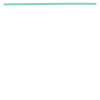

In [45]:
edge_geometry

In [57]:
from shapely.geometry import LineString

i = 1
edge_geometry = LineString(routes[i][2]['geometry'])
points = [(point[1],point[0]) for point in edge_geometry.coords]
points

[(51.0907154, -114.1520064),
 (51.0907211, -114.1514661),
 (51.0907201, -114.151257)]

In [51]:
print(edge_geometry.coords[0])

(-114.1520064, 51.0907154)


In [52]:
from shapely.geometry import LineString, loads

edge_geometry = loads(routes[i]['geometry'])
 
points = [(point[1],point[0]) for point in edge_geometry.coords]
points

ImportError: cannot import name 'loads' from 'shapely.geometry' (c:\Users\Hadia\anaconda3\envs\ox\Lib\site-packages\shapely\geometry\__init__.py)

In [36]:
d=routes[0]
d

(5192190535,
 30920053,
 {'osmid': 4684553,
  'oneway': False,
  'name': 'Valiant Drive NW',
  'highway': 'residential',
  'length': 41.866,
  'grade': -0.048,
  'grade_abs': 0.048,
  'speed_kph': 42.2,
  'travel_time': 3.6,
  'bearing': 89.2,
  'slopized_length': 2.0095680000000002,
  'edge_tree_count': 994,
  'geometry': <LINESTRING (-114.153 51.091, -114.152 51.091)>})

In [ ]:
linstring = d[2]['geometry']

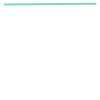

In [35]:
linstring = d[2]['geometry']
linstring

In [23]:



linestrings = [d[2]['geometry'] for d in routes]

In [24]:
linestrings

[<LINESTRING (-114.153 51.091, -114.152 51.091)>,
 <LINESTRING (-114.152 51.091, -114.151 51.091, -114.151 51.091)>,
 <LINESTRING (-114.151 51.091, -114.151 51.091, -114.15 51.091)>,
 <LINESTRING (-114.15 51.091, -114.149 51.091)>,
 <LINESTRING (-114.149 51.091, -114.147 51.091)>,
 <LINESTRING (-114.147 51.091, -114.147 51.091, -114.147 51.091, -114.147 51....>,
 <LINESTRING (-114.146 51.091, -114.146 51.091)>,
 <LINESTRING (-114.146 51.091, -114.145 51.091)>,
 <LINESTRING (-114.145 51.091, -114.144 51.09)>,
 <LINESTRING (-114.144 51.09, -114.143 51.089)>,
 <LINESTRING (-114.143 51.089, -114.141 51.089)>,
 <LINESTRING (-114.141 51.089, -114.141 51.089, -114.141 51.088, -114.141 51....>,
 <LINESTRING (-114.141 51.088, -114.141 51.088)>,
 <LINESTRING (-114.141 51.088, -114.141 51.088, -114.14 51.087)>,
 <LINESTRING (-114.14 51.087, -114.14 51.087, -114.139 51.087, -114.139 51.08...>,
 <LINESTRING (-114.139 51.087, -114.139 51.087, -114.138 51.087, -114.138 51....>,
 <LINESTRING (-114.137